In [29]:
import clmm
from clmm import Cosmology
import numpy as np
import matplotlib.pyplot as plt

cosmo = Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

<font size=5> <font color='red'>[INCOMPLETE]</font> MODELLING of Quadrupole and Monopole from Adhikari et al.  </font>

Can be skipped! The same code has been implemented by Callum!

Text(0, 0.5, '$\\Sigma$')

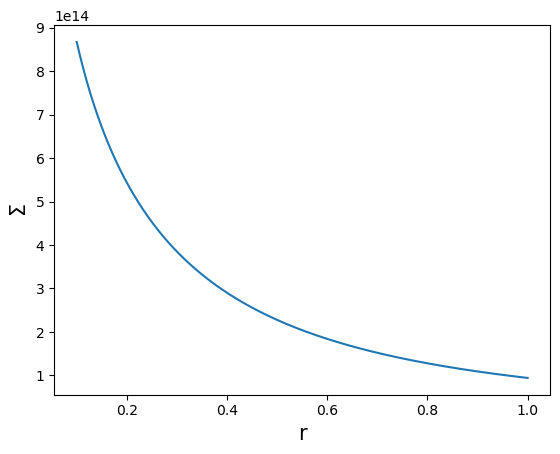

In [30]:
r_proj = np.linspace(0.1,1.0,1000)
mdelta=10E14
cdelta=4.0
z_cl=0.3
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

plt.plot(r_proj, sigma)
plt.xlabel('r', fontsize=15)
plt.ylabel('$\Sigma$', fontsize=15)

In [220]:
import scipy
def gamma_tangential_monopole(r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw'):
    kappa_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    f = lambda r_i: r_i*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    integrate = np.vectorize(pyfunc = scipy.integrate.quad_vec)
    
    integral, err = integrate(f,0,r)
 
    
    return (2/r**2)*integral - kappa_0
    

In [62]:
%%time

g_t_monopole = gamma_tangential_monopole(r_proj, mdelta, cdelta, z_cl, cosmo, hpmd='nfw')

CPU times: user 2min 5s, sys: 43.8 ms, total: 2min 5s
Wall time: 2min 5s


Text(0, 0.5, '$\\Delta\\Sigma$  (MONOPOLE)')

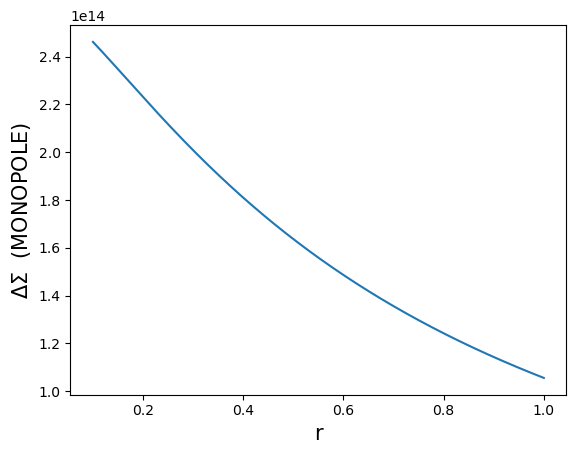

In [66]:
plt.plot(r_proj, g_t_monopole)
plt.xlabel('r', fontsize=15)
plt.ylabel('$\Delta\Sigma$  (MONOPOLE)', fontsize=15)

In [ ]:
def g_tangential_quadrupole(r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw'):
    kappa_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    f1 = lambda r_i: (r_i**3)*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    f2 = lambda r_i: (r_i**3)*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    
    integrate = np.vectorize(pyfunc = scipy.integrate.quad_vec)
    
    integral1, err = integrate(f1,0,r)
    integral2, err = integrate(f2,r,np.inf)
 
    
    return (2/r**2)*integral - kappa_0

<font size= 8> ## TAE's IMPLEMENTATION ##</font>

<font size=5> MODELLING of Quadrupole and Monopole from Shin et al. </font>

Using the expressions for $\Delta\Sigma^{4\theta}$ and $\Delta\Sigma^{Const}$ (estimators for quadrupole) and implementing them using CLMM functionality. 

In [32]:
from scipy.interpolate import InterpolatedUnivariateSpline
def compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, (r_arr**3)*sigma_0_arr*eta_0_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_1 = (3/(r**4)) * integral_vec(0, r)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0),r)
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return (ell/4.0)*(2*I_1 - sigma_0*eta_0), eta_0_interpolation_func

def compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000 ,delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, sigma_0_arr*eta_0_arr/r_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_2 = integral_vec(r, np.inf)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0), r)*r
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return (ell/4.0)*(2*I_2 - sigma_0*eta_0), eta_0_interpolation_func

def compute_delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200):
    return clmm.compute_excess_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

1.49102485026816


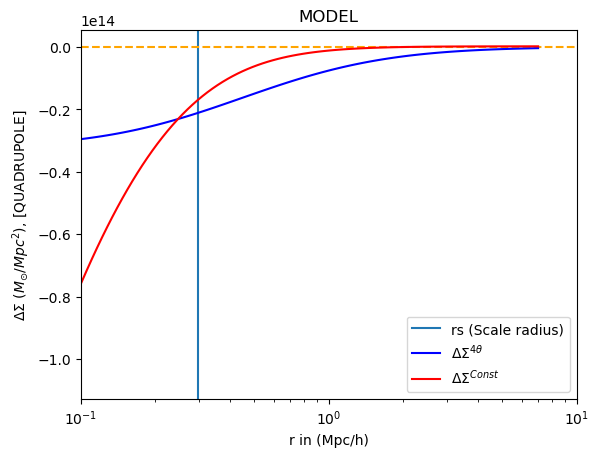

In [33]:
q=2/3
ell = (1-q**2)/(1+q**2)
#ell=0.47
r = np.logspace(-1,1,100)*0.7

mdelta=2.5*1E14
delta_mdef = 200
cdelta=5.0
z_cl=0.3

rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta
print(rdelta)

plt.axvline(rs, label='rs (Scale radius)')
plt.axhline(0, linestyle='--', color='orange')

ds4theta, eta_func = compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{4\theta}$'
plt.plot(r, ds4theta/0.7, 'b-',label=label)
#plt.plot(r, eta_func(r), 'b.', label=label+str(' eta_0'))



dsconst, eta_func = compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{Const}$'
plt.plot(r, dsconst/0.7, 'r-',label=label)
#plt.plot(r, eta_func(r), 'r.', label=label+str(' eta_0'))


plt.xlabel('r in (Mpc/h)')
plt.ylabel(r'$\Delta\Sigma$ ($M_{\odot}/Mpc^{2}$), [QUADRUPOLE]')
plt.xscale('log')
plt.title('MODEL')
plt.xlim([0.1,10.0])
plt.legend()

<font size= 8>## CALLUM's IMPLEMENTATION ## </font>

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from astropy.cosmology import FlatLambdaCDM
from astropy import constants
import sys
sys.path.insert( 0 , '/pbs/home/c/cmurray/magnification_and_dust/')

"""
This is a pure python code to calculate the shear profiles around elliptical mass density following Adhikari 2014 
(https://arxiv.org/pdf/1407.1128.pdf)
"""


# surface mass density {dimensionless}
def sigma_0( x ):

	# this is my way of dealing with the discontinuity at x=1...
	# if the change is smaller than this it does not help 
	if x < 1:
		return ( 2 / ( x**2 -1 ) ) * \
			   ( 1 - 2 * np.arctanh( np.sqrt( ( 1- x ) / ( 1 + x ) ) ) / (  1 - x**2 )**0.5 )
	#if x == 1:
	#    return 2/3
	#else:
	x = x + 7e-5 
	return ( 2 / ( x**2 -1 ) ) * \
			   ( 1 - 2 * np.arctan( np.sqrt( ( x - 1 ) / ( x + 1 ) ) ) / (  x**2  - 1)**0.5 )
	
sigma_0 = np.vectorize( sigma_0 )


def eta_0( x ):
	dx = 1e-6
	xh = x + dx
	xl = x - dx
	sh = np.log( sigma_0( xh ) )
	sl = np.log( sigma_0( xl ) )
	return x * ( sh - sl ) / ( 2 * dx )

def I_1_integrand( x ):
	return np.power( x , 3 ) * sigma_0( x ) * eta_0( x )

def I_1( x ):
	i = integrate.quad( I_1_integrand , 0 , x )[0]
	return i * 3 / x ** 4

def I_2_integrand( x ):
	return sigma_0( x ) * eta_0( x ) / x

def I_2( x ):
	i = integrate.quad( I_2_integrand , x , 5e2 )[0]
	return i

I_2 = np.vectorize( I_2 )

# does the heavy lifting for quad_shear_t
def __quad_shear_t__( x ):
	a = sigma_0( x ) * eta_0( x )
	return ( a -  I_1( x ) - I_2( x ) ) 

__quad_shear_t__ = np.vectorize( __quad_shear_t__ )

def __alt_qst__( x ):
	return np.interp( x , xx , qst )

def quad_shear_t( x , psi , e ):
	return ( e / 2 ) * __alt_qst__( x ) * np.cos( 2 * psi )

quad_shear_t = np.vectorize( quad_shear_t )

def __quad_shear_x__( x ):
	return ( -  I_1( x ) + I_2( x ) )

__quad_shear_x__ = np.vectorize( __quad_shear_x__ )

def __alt_qsx__( x ):
	return np.interp( x , xx , qsx )
	
def quad_shear_x( x , psi , e ):
	return ( e / 2 ) * __alt_qsx__( x ) * np.sin( 2 * psi )

def av_sigma_0_integrand( x ):
	return x * sigma_0( x )

def av_sigma_0( x ):
	i = integrate.quad( av_sigma_0_integrand , 0 , x )[0]
	return 2 * i / x ** 2

__av_sigma_0__ = np.vectorize( av_sigma_0 )


def __mono_shear_t__( x ):
	return av_sigma_0( x ) - sigma_0( x )

__mono_shear_t__ = np.vectorize( __mono_shear_t__ )

def __alt_mono_shear_t__( x ):
	return np.interp( x , xx , mst )

def mono_shear_t( x ):
	return __alt_mono_shear_t__( x )

# monopole + quadrupole
def shear_t( x , psi , e ):
	return mono_shear_t( x ) + quad_shear_t( x , psi , e )


# only the quadrupole is non zero
def shear_x( x , psi, e ):
	return quad_shear_x( x , psi, e )


#shear = np.vectorize( shear )

direc = ''



# rather than computing each time we have 
# computed and saved these values
xx = np.logspace( -5 , 5  , num = 200 )
#qst = np.load( direc + 'qst.npy')
#qsx = np.load( direc + 'qsx.npy')
#mst = np.load( direc + 'mst.npy')

# average sigma for deflection angle
as0 = __av_sigma_0__( xx )
qst = __quad_shear_t__( xx )
qsx = __quad_shear_x__( xx )
mst = __mono_shear_t__( xx )


def av_sigma( x ):
	return np.interp( x , xx , as0 )


class triaxial_lens:
	
	def __init__( s , M_lens , c , z_lens , e , H0 = 70 , Om0 = 0.3 ):
		# lens mass [M_sun] 
		s.M_lens = M_lens
		# lens concentration
		s.c = c
		# lens redshift
		s.z_lens = z_lens
		# lens ellipticity
		s.e = e
		# set up the cosmology
		s.cosmo = FlatLambdaCDM( H0 = H0 , Om0 = Om0 )
		# critical density of the universe [M_sun / Mpc^3]
		s.rho_c = s.cosmo.critical_density( s.z_lens ).to('M_sun/Mpc^3').value
		# mean matter density of the universe [M_sun / Mpc^3]
		s.rho_m = s.rho_c * s.cosmo.Om( s.z_lens )
		# halo definition
		s.delta = 200
		# 
		s.delta_c = s.char_overdensity( c )
		# [Mpc]
		s.r200 = s.r200_calc()
		# scale radius [Mpc]
		s.rs = s.rs_calc()
		# scale radius radians
		s.theta_s = s.rs / s.cosmo.angular_diameter_distance( s.z_lens ).value
	
	# characteristic overdensity, dimensionless
	def char_overdensity( s , c ):
		return ( s.delta / 3. ) * ( c**3 / ( np.log( 1 + c ) - c / ( 1 + c ) ) )
	
	# calculate r 200
	def r200_calc( s ):
		r2003 = ( 3.0 * s.M_lens ) / ( 4.0 * np.pi * s.delta * s.rho_m )
		return r2003 ** ( 1. / 3. )
	
	# scale radius [Mpc]
	def rs_calc( s ):
		return s.r200 / s.c
	
	# this is the prefactor which gives the correct amplitude
	# to the signal calculated above
	def A( s ):
		return s.rs * s.rho_m * s.delta_c
								   
	# excess surface density
	# theta in radians
	# psi in radians
	# e ellipticity
	# units [M_sun/pc^2]
	def esd_t( s , theta , psi):
		x = theta / s.theta_s
		# factor of 1e12 changes units from M_sun/Mpc^2 -> M_sun/pc^2
		return s.A() * shear_t( x , psi, s.e ) / 1e12


	def esd_x( s , theta , psi):
		x = theta / s.theta_s
		# factor of 1e12 changes units from M_sun/Mpc^2 -> M_sun/pc^2
		return s.A() * shear_x( x , psi, s.e ) / 1e12

	def gamma_t( s , theta , psi, z_gal ):
		return s.esd_t( theta , psi) / s.sigma_cr( s.z_lens , z_gal )
    
	def gamma_x( s , theta , psi, z_gal ):
		return s.esd_x( theta , psi) / s.sigma_cr( s.z_lens , z_gal )

	# units M_sun/pc^2
	def sigma_cr( s , z_lens , z_source ):
		G = constants.G
		c = constants.c
		D_s = s.cosmo.angular_diameter_distance( z_source )
		D_d = s.cosmo.angular_diameter_distance( z_lens )
		D_ds = s.cosmo.angular_diameter_distance_z1z2( z_lens , z_source )
		return ( ( c**2 / (4*np.pi*G) ) * D_s / ( D_d * D_ds ) ).to('M_sun / pc^2').value

	# monopole convergence
	def kappa_0( s , theta , z_gal ):
		x = theta / s.theta_s
		return s.A() * sigma_0( x ) / 1e12 / s.sigma_cr( s.z_lens , z_gal )

	def sigma( s , theta  ):
		x = theta / s.theta_s
		return s.A() * sigma_0( x ) / 1e12 

	# the deflection angle in radians
	def alpha( s, theta , z_gal ):
		x = theta / s.theta_s
		return s.A() * theta * av_sigma( x ) / s.sigma_cr( s.z_lens , z_gal ) / 1e12

	# dimensionless esd
	def template( s , theta ):
		x = theta / s.theta_s
		return shear_t( x , 0 , s.e )
    
    # Gamma 1 (r, theta):
	def gamma_1( s, theta, psi, z_gal):
		return -1*s.gamma_t(theta , psi=psi, z_gal=z_gal )*np.cos(2*psi) + s.gamma_x( theta , psi=psi, z_gal=z_gal )*np.sin(2*psi)
    
    # Gamma 2 (r, theta):
	def gamma_2( s, theta, psi, z_gal):
		return -1*s.gamma_t( theta , psi=psi, z_gal=z_gal )*np.sin(2*psi) - s.gamma_x( theta , psi=psi, z_gal=z_gal )*np.cos(2*psi)
    
	def delta_sigma_4theta(s, theta, psi, z_gal):
		return s.sigma_cr(z_lens, z_source=z_gal)*np.sum(s.gamma_1(theta, psi=psi, z_gal=z_gal)*np.cos(4*psi) + s.gamma_2(theta, psi, z_gal)*np.sin(4*psi), axis=0)/np.shape(psi)[1]
    
	def delta_sigma_const(s, theta, psi, z_gal):
		return s.sigma_cr(z_lens, z_source=z_gal)*np.sum(s.gamma_1(theta, psi=psi, z_gal=z_gal), axis=0)/np.shape(psi)[1]


/tmp/ipykernel_46607/2077186905.py:22: RuntimeWarning: invalid value encountered in arctanh
  ( 1 - 2 * np.arctanh( np.sqrt( ( 1- x ) / ( 1 + x ) ) ) / (  1 - x**2 )**0.5 )
/tmp/ipykernel_46607/2077186905.py:45: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  i = integrate.quad( I_1_integrand , 0 , x )[0]
/tmp/ipykernel_46607/2077186905.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i = integrate.quad( I_2_integrand , x , 5e2 )[0]
/tmp/ipykernel_46607/20771

In [12]:
## Define a cluster:

M_lens = 2*1E14
c = 4.0
z_lens = 0.3
q = 2/3
e = (1 - q**2)/(1 + q**2)
z_gal = 1.0
t = triaxial_lens(M_lens, c, z_lens, e)

Text(0, 0.5, '$\\Delta\\Sigma^{const}$')

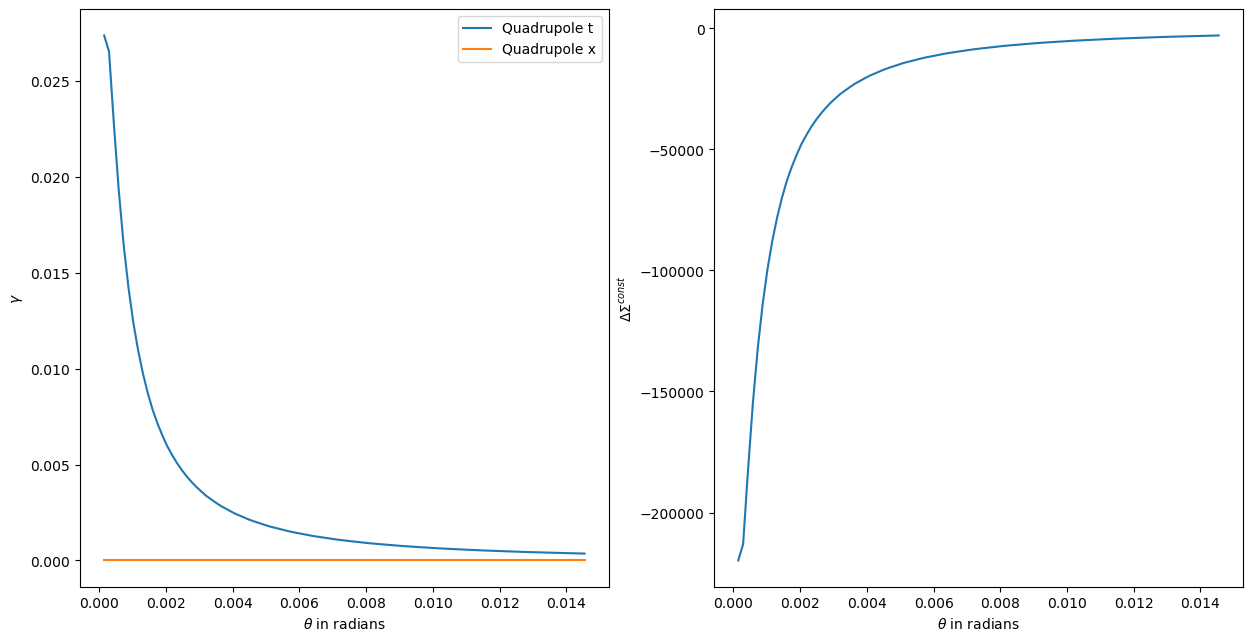

In [13]:
theta = np.linspace(0.5/60*np.pi/180, 50/60*np.pi/180, 100)
psi = np.pi/2

delta_sigma_t = t.esd_t(theta, psi=psi)
shears_t = t.gamma_t(theta, psi, z_gal)
plt.figure(figsize=[15,7.5])
plt.subplot(121)
plt.plot(theta,shears_t, label='Quadrupole t')
delta_sigma_x = t.esd_x(theta, psi=psi)
shears_x = t.gamma_x(theta,psi=psi, z_gal=z_gal)
plt.plot(theta,shears_x, label='Quadrupole x')
plt.legend()
plt.xlabel(r'$\theta$ in radians')
plt.ylabel(r'$\gamma$')


plt.subplot(122)
gamma_const = t.esd_x(theta, psi=psi) - t.esd_t(theta, psi=psi)
delta_sigma_const = gamma_const*t.sigma_cr(t.z_lens, z_gal)
plt.plot(theta, delta_sigma_const)
plt.xlabel(r'$\theta$ in radians')
plt.ylabel(r'$\Delta\Sigma^{const}$')

/tmp/ipykernel_46607/302144706.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = plt.pcolormesh(1000*x, 1000*y, Z, cmap='RdBu', shading="auto", vmin=-0.05, vmax=0.05)
/tmp/ipykernel_46607/302144706.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = plt.pcolormesh(1000*x, 1000*y, Z, cmap='RdBu', shading="auto", vmin=-0.0005, vmax=0.0005)


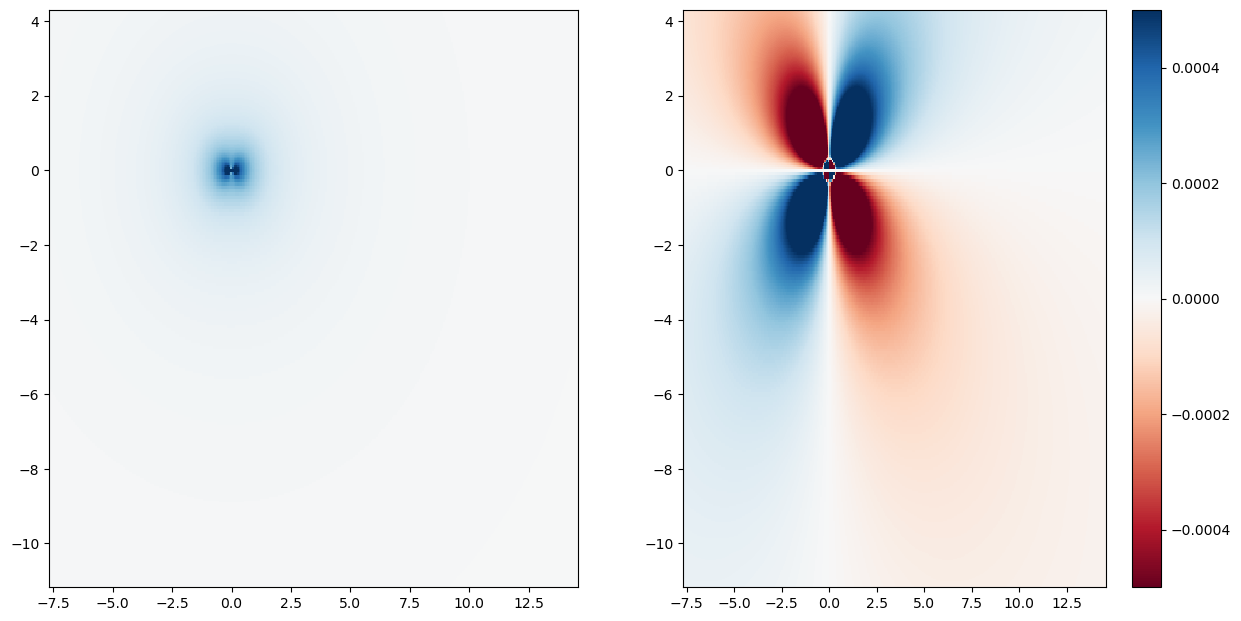

In [16]:
import numpy as np
import matplotlib.pyplot as plt




theta = np.linspace(0.5/60*np.pi/180, 50/60*np.pi/180, 1000)
psi =  np.linspace(0.001*np.pi/180, 2*np.pi, 1000)
x = theta*np.cos(psi)
y = theta*np.sin(psi)
#x_center = 0.5 * (x[:-1] + x[1:])
#y_center = 0.5 * (y[:-1] + y[1:])

# pcolormesh needs the pixel edges for x and y
# and with default flat shading, Z needs to be evaluated at the pixel center
plt.figure(figsize=[15,7.5])
plt.subplot(121)
def z_func(x, y):
    theta = np.sqrt(x**2+y**2)
    psi = np.arctan2(y,x)
    return t.gamma_t(theta, psi, z_gal)
X, Y = np.meshgrid(x, y)

Z = z_func(X, Y)

plot = plt.pcolormesh(1000*x, 1000*y, Z, cmap='RdBu', shading="auto", vmin=-0.05, vmax=0.05)

plt.subplot(122)
def z_func(x, y):
    theta = np.sqrt(x**2+y**2)
    psi = np.arctan2(y,x)
    return t.gamma_x(theta, psi, z_gal)
X, Y = np.meshgrid(x, y)

Z = z_func(X, Y)

plot = plt.pcolormesh(1000*x, 1000*y, Z, cmap='RdBu', shading="auto", vmin=-0.0005, vmax=0.0005)

# contour needs the centers
#cset = plt.contour(X, Y, Z, cmap='gray')
#plt.clabel(cset, inline=True)

plt.colorbar(plot)
#plt.savefig('plot_z_flat.png')

<font size=8> COMPARING THE TWO IMPLEMENTATIONS! </font>

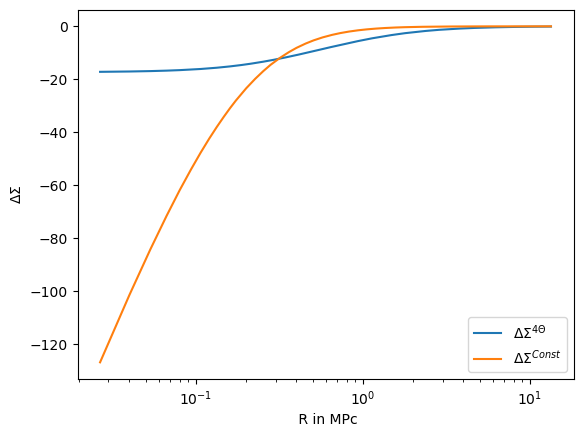

In [60]:
######## ADHIKARI IMPLEMENTATION BY CALLUM ##########
# Create a triaxial lens by the class definition for CALLUM's code:

M_lens = 2.5*1E14
c = 4.0
z_lens = 0.3
q = 2/3
e = (1 - q**2)/(1 + q**2)
z_gal = 1.0
t = triaxial_lens(M_lens, c, z_lens, e)

# Make the grid in distance and angle to compute the monopole + quadrupole shears:
theta = np.linspace(0.1/60*np.pi/180, 50/60*np.pi/180, 1000)
psi =  np.linspace(0.001*np.pi/180, 2*np.pi, 1000)
Theta, Psi = np.meshgrid(theta, psi)

# PLOTTING Delta Sigma:

delta_sigma_4theta = t.delta_sigma_4theta(theta=Theta, psi=Psi, z_gal=z_gal)
r_dist = theta*cosmo.eval_da(t.z_lens)
plt.plot(r_dist, delta_sigma_4theta, label='$\Delta\Sigma^{4\Theta}$')


delta_sigma_const = t.delta_sigma_const(theta=Theta, psi=Psi, z_gal=z_gal)
plt.plot(r_dist, delta_sigma_const, label='$\Delta\Sigma^{Const}$')
plt.xlabel(r' R in MPc')
plt.ylabel(r'$\Delta\Sigma$')
plt.xscale('log')
plt.legend()

1.49102485026816


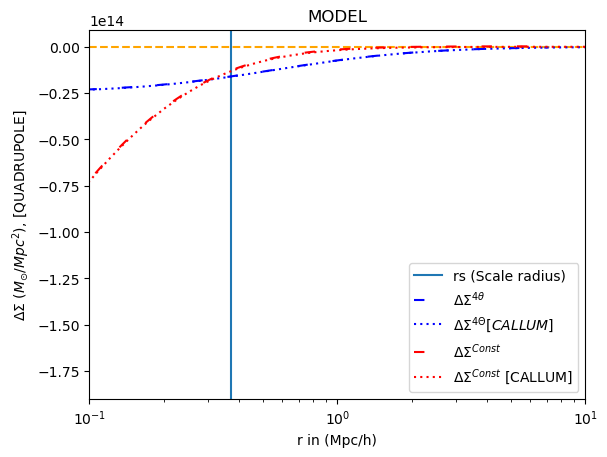

In [81]:
######### TAE's IMPLEMENTATION ###########

#Define properties of a triaxial lens using clmm-infused functions for TAE's method:
q=2/3
ell = (1-q**2)/(1+q**2)
mdelta=2.5*1E14
delta_mdef = 200
cdelta=4.0
z_cl=0.3

rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta
print(rdelta)

plt.axvline(rs, label='rs (Scale radius)')
plt.axhline(0, linestyle='--', color='orange')

# Grid of distances to compute delta sigma:
r = np.logspace(-1,1,100)*0.7

# PLOTTING Delta Sigma:

ds4theta, eta_func = compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{4\theta}$'
plt.plot(r, ds4theta/0.7, color='blue',label=label, linestyle=(0, (5, 12)))
plt.plot(r_dist, delta_sigma_4theta*1E12/0.7, label='$\Delta\Sigma^{4\Theta} [CALLUM]$', color='blue', linestyle=(0, (1, 2)))
#plt.plot(r, eta_func(r), 'b.', label=label+str(' eta_0'))



dsconst, eta_func = compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{Const}$'
plt.plot(r, dsconst/0.7, color='red',label=label, linestyle=(0, (5, 12)))
plt.plot(r_dist, delta_sigma_const*1E12/0.7, label='$\Delta\Sigma^{Const}$ [CALLUM]', color='red', linestyle=(0, (1, 2)))
#plt.plot(r, eta_func(r), 'r.', label=label+str(' eta_0'))


plt.xlabel('r in (Mpc/h)')
plt.ylabel(r'$\Delta\Sigma$ ($M_{\odot}/Mpc^{2}$), [QUADRUPOLE]')
plt.xscale('log')
plt.title('MODEL')
plt.xlim([0.1,10.0])
plt.legend()

<font size=4 color='green'> And, they are consistent ever after! <\font>